Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression.

You will learn how to:

Implement a 2-class classification neural network with a single hidden layer
Use units with a non-linear activation function, such as tanh
Compute the cross entropy loss
Implement forward and backward propagation

1 - Packages
Let's first import all the packages that you will need during this assignment.

numpy is the fundamental package for scientific computing with Python.
sklearn provides simple and efficient tools for data mining and data analysis.
matplotlib is a library for plotting graphs in Python.
testCases provides some test examples to assess the correctness of your functions
planar_utils provide various useful functions used in this assignment


In [4]:
import numpy as np   # for working with vectors
import matplotlib.pyplot as plt  #for graph plotting
import sklearn
import sklearn.datasets
import sklearn.linear_model
from test_cases import *
%matplotlib inline
np.random.seed(1) # set a seed so that the results are consistent

below is the implementation of sigmoid function which is used to squash the output between 0 and 1 for uniformity of scale.
With this a load_dataset_function is used to generte a shape that the model will detect in which location red dots are located and in which location blue dots are located.
And then extra data sets.

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400  # number of examples
    N = int(m / 2)  # number of points per class
    D = 2  # dimensionality
    X = np.zeros((m, D))  # data matrix where each row is a single example
    Y = np.zeros((m, 1), dtype='uint8')  # labels vector (0 for trapezoid, 1 for background)
    a = 4  # length of the shorter parallel side
    b = 8  # length of the longer parallel side
    h = 6  # height of the trapezoid

    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2  # theta
        r = np.linspace(a, b, N) + np.random.randn(N) * 0.2  # distance from the center

        # Modified trapezoid generation to make it similar to the noisy_moons dataset
        X[ix] = np.c_[
            r * np.cos(t) + 2 * np.random.randn(N),  # added random noise to x-coordinate
            h / 2 + r * np.sin(t) + 0.5 * np.cos(3 * t) + 2 * np.random.randn(N)  # added random noise to y-coordinate
        ]

        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y



def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

Input Features (X): The positions of each point in the dataset are stored in X. Specifically, X[0, :] represents the x-coordinates, and X[1, :] represents the y-coordinates of the points.

Labels (Y): The color labels of each point are stored in Y. The labels indicate whether a point belongs to the trapezoid (class 0) or the background (class 1). For example, if Y[0, :] = 0, it means that the first point in the dataset belongs to the trapezoid (and its position is given by the corresponding values in X). If Y[1, :] = 1, it means that the second point belongs to the background.

In [6]:
X, Y = load_planar_dataset()
print(X)


[[ 1.10172010e+00  4.31387494e+00  4.65137355e+00  6.85473484e+00
   2.86275986e+00  3.65123266e+00 -8.60421672e-01  2.29867773e+00
   4.76993156e+00  6.76145486e+00  3.16193919e+00  7.95240030e+00
   7.95049414e+00  3.98931804e+00 -1.18801760e+00  9.21025598e-01
   2.78689106e+00  6.46881000e+00  5.06910565e+00 -1.53937694e-01
   4.24725274e+00  7.06290816e+00  3.36353798e+00  2.51593628e+00
   7.70827186e+00  4.93749816e+00  3.13527961e+00  5.07829185e+00
   4.13261914e+00  2.98835056e+00  6.81442181e+00  6.51452871e+00
   6.14379288e+00  4.51436080e+00  6.58746760e+00  3.70900567e+00
   5.16213378e+00  5.80101561e+00  4.27350285e+00  7.16712525e+00
   4.81484668e+00  8.87574291e-01  1.90931601e+00  5.12845017e+00
   2.94145876e+00  4.99356367e+00  1.95842462e+00  3.95462573e+00
   3.03005866e+00  5.88324223e+00  2.21558924e+00  5.94928610e+00
   5.08493462e+00  2.50354264e+00  5.77408280e+00  9.25732332e-01
   1.12975850e+00  3.92447460e+00  1.73341776e+00  1.10029225e+00
   2.99204

To plot the graph and see the scatter of points

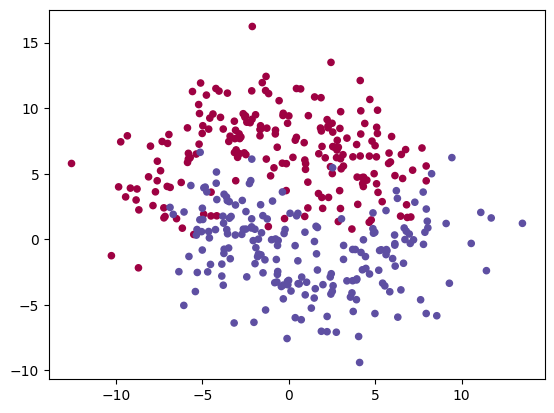

In [30]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y, s=20, cmap=plt.cm.Spectral)

Lets apply simple logistic regression and see if it can be detect which region has red markers and which one has blue markers

In [32]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T)

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV()

Accuracy of logistic regression: 23 % (percentage of correctly labelled datapoints)


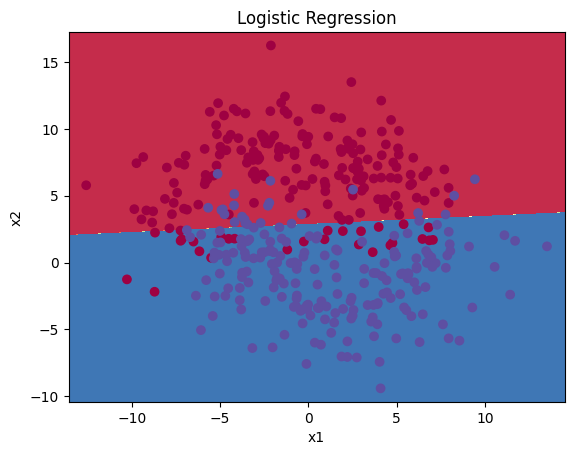

In [33]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

As we can see that the accuracy  is just 23 % so the data cannot be linearly differentiable so linear logistic regression is not a good option . so one need to include non-linear activation function such as tanh() non-linear activation function and try to build a neural network with on hidden layer.

General methodology to implement neural network 
1. Define the neural network structure ( # of input units, # of hidden units, etc). 
2. Initialize the model's parameters 
3. Loop: - Implement forward propagation - Compute loss - Implement backward propagation to get the gradients - Update parameters (gradient descent)
and finally make predictions.

Defining the neural network structure
Exercise: Define three variables: - n_x: the size of the input layer - n_h: the size of the hidden layer (set this to 4) - n_y: the size of the output layer

Hint: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [47]:
print(X.shape)
print(Y.shape)

(2, 400)
(1, 400)


1. Defining the neural network structue size of input layer , hidden layer and output layer .

In [12]:
def layer_size(X,Y):
    #n_x = size of input layer 
    #n_h : the size of hidden layer
    #n_y : size of output layer
    n_x = X.shape[0]
    n_h = 4 
    n_y = Y.shape[0]
    return(n_x , n_h , n_y)
   

In [14]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_size(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


2. Initialise the model parameters 

In [15]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


3. Loop : perform forward_propagation ()

In [16]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    # performing the forward propagation to compute these fur values . 
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    # this line of code is added to ensure that the output A2 has the shape 1 , output layer so it should be 1 , 1.
    assert(A2.shape == (1, X.shape[1]))
    
    # Values needed in the backpropagation are stored in "cache". This will be given as an input to the backpropagation
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [59]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.26281864019752443 0.09199904522700109 -1.3076660128732143 0.21287768171914198


Now as we have computed the value of A2 so now we can compute the cost function for this model

In [17]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    m = Y.shape[1] 
    logprobs = logprobs = np.multiply(Y ,np.log(A2)) + np.multiply((1-Y), np.log(1-A2))
    cost = (-1/m) * np.sum(logprobs)
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    return cost


In [6]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6930587610394646


4. Implement backward propagation to find out gradient descent 

In [18]:

def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    # using the following equations lets perfrom backward propagation .
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) *(np.sum(dZ2,axis=1,keepdims=True))
    dZ1 = np.dot(W2.T,dZ2) * (1 - np.power(A1,2))
    dW1 = (1/m) *(np.dot(dZ1,X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [8]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


In [19]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
   
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads,1.2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


Here we will combine all the points and build a model

In [20]:
# NN_model
def nn_model(X, Y, n_h, learning_rate, num_iterations = 10000, print_cost=False):
    n_x = layer_size(X, Y)[0]
    n_y = layer_size(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost"
        cost = compute_cost(A2, Y, parameters)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        grads = backward_propagation(parameters, cache, X, Y)
        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, learning_rate)
        # If print_cost=True, Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters

In [24]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 1.02,num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692739
Cost after iteration 1000: 0.000257
Cost after iteration 2000: 0.000127
Cost after iteration 3000: 0.000084
Cost after iteration 4000: 0.000063
Cost after iteration 5000: 0.000050
Cost after iteration 6000: 0.000042
Cost after iteration 7000: 0.000036
Cost after iteration 8000: 0.000031
Cost after iteration 9000: 0.000028
W1 = [[-0.65400312  1.21068652]
 [-0.75688005  1.38443617]
 [ 0.57449374 -1.0957478 ]
 [ 0.76242342 -1.40517716]]
b1 = [[ 0.2841426 ]
 [ 0.34699428]
 [-0.23981061]
 [-0.35351855]]
W2 = [[-2.42329584 -3.22274999  1.97978376  3.31771228]]
b2 = [[0.20282644]]


In [25]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    ### END CODE HERE ###
    
    return predictions

In [26]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))


predictions mean = 0.6666666666666666


Cost after iteration 0: 0.692181
Cost after iteration 1000: 0.162511
Cost after iteration 2000: 0.157594
Cost after iteration 3000: 0.157386
Cost after iteration 4000: 0.157673
Cost after iteration 5000: 0.174345
Cost after iteration 6000: 0.160948
Cost after iteration 7000: 0.171057
Cost after iteration 8000: 0.157304
Cost after iteration 9000: 0.161348


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

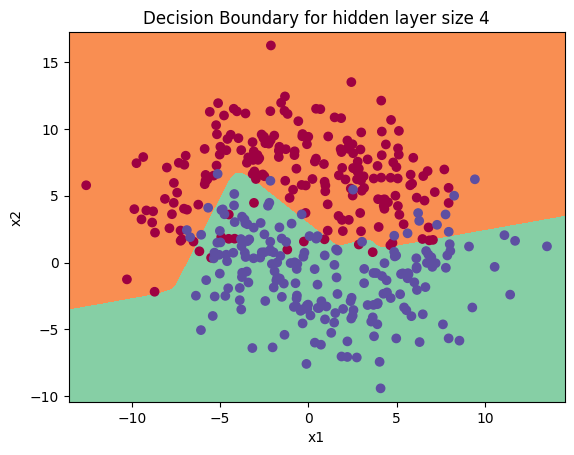

In [31]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, 4, 1.2 , num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [32]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 92%


Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 87.0 %
Accuracy for 3 hidden units: 93.25 %
Accuracy for 4 hidden units: 92.0 %
Accuracy for 5 hidden units: 92.75 %
Accuracy for 20 hidden units: 94.25 %
Accuracy for 50 hidden units: 95.5 %


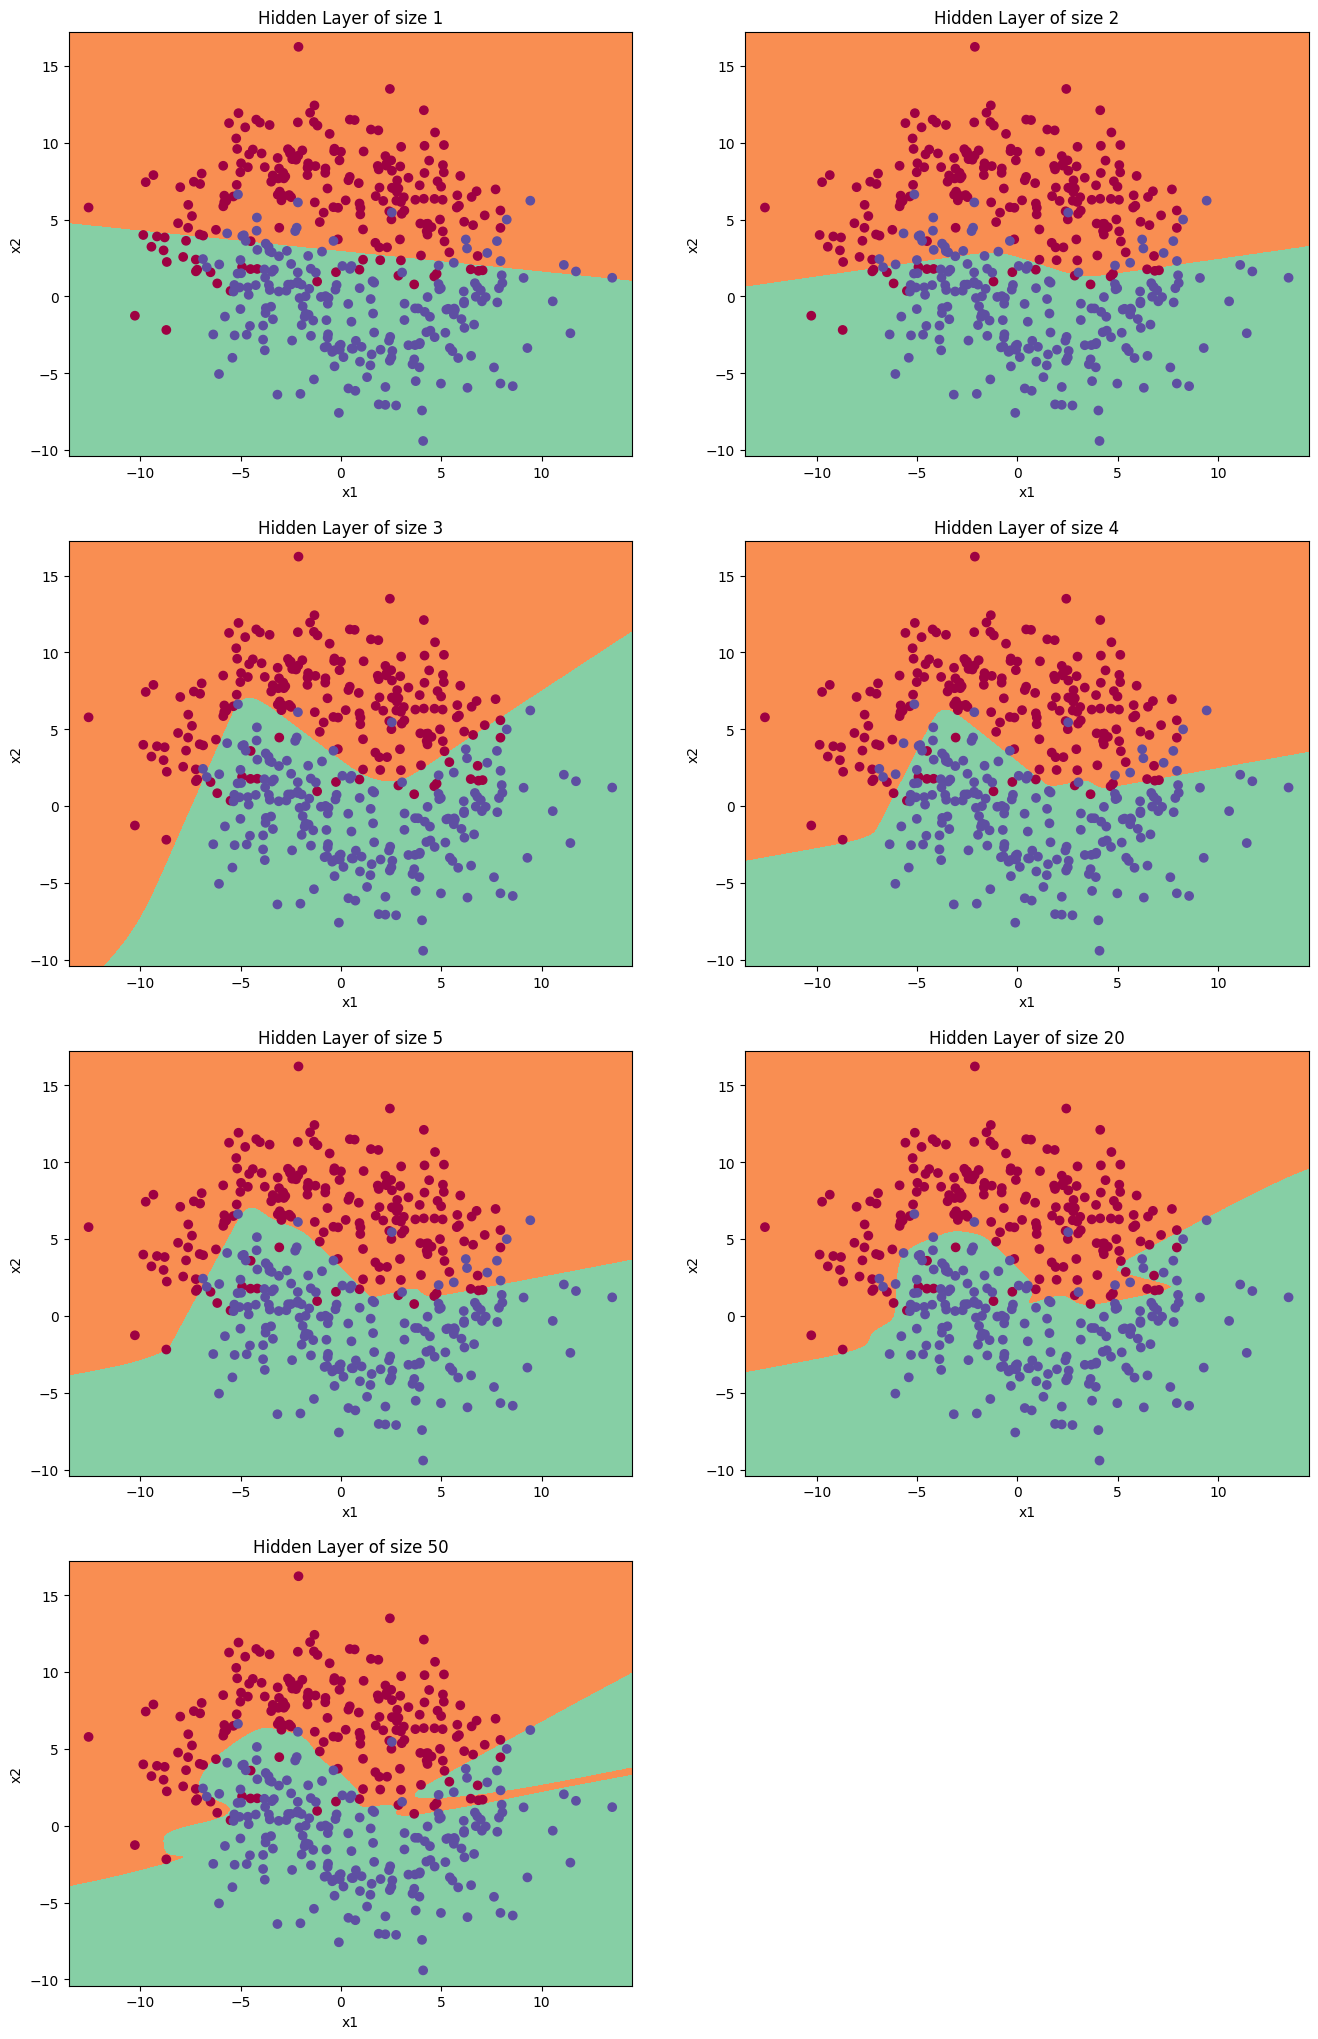

In [33]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h,1.2, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Interpretation:

The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data.
The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to fits the data well without also incurring noticeable overfitting.
You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting.

1. what if we change the learning rate , lets assume learning rate = 0.7 lets try to compare how the accuracy changes by changing learning rate but keeping number of iterations same

In [37]:
import pandas as pd

# Create an empty list to store results
results = []

# Initial learning rate
learning_rate = 1.2

# Iterate through learning rates
while learning_rate >= 0.2:
    # Train the neural network and get accuracy
    parameters = nn_model(X, Y, n_h, learning_rate, num_iterations=10000)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100)

    # Store results
    results.append({'Learning Rate': learning_rate, 'Accuracy': accuracy})

    # Decrease learning rate by 0.1
    learning_rate -= 0.1

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(results)

# Write the DataFrame to a CSV file
df.to_csv('learning_rate_accuracy.csv', index=False)


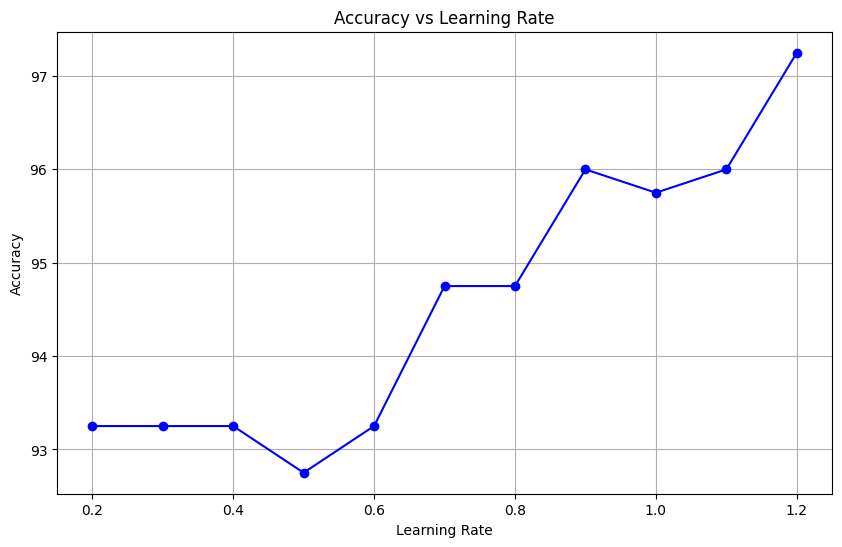

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('learning_rate_accuracy.csv')

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(df['Learning Rate'], df['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


From this the interpretation that can be drawn is that :-
With the increase in learning rate the accuracy  of the model prediction also increases .